# **FE Stats Classifier Model Analysis**

In [11]:
# [FE_Stats_Data_Analysis]: Need to include path to the singleton pattern impl due to a dependency from the CharacterStatsAnalysis class
# Note: The directory is based of the current working dir of the notebook since the class base directory changes to this one
import sys, os

sys.path.append(os.path.abspath('src/Singleton'))

import torch
import torch.utils.data as torch_data
import src.Models.ModelAnalysis as ma
import pickle
import numpy
from src.Models.FEMLPClassifier import FEMLPClassifier
from src.Models.FECNNClassifier import FECNNClassifier
from src.Models.StatsDataset import StatsDataset
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

torch.manual_seed(42)

accel_device = "cuda:0"

dtype = torch.float32

batch_size = 4

num_epochs = 100

label_names = ["Marth","Linde","Palla","Alm","Roy","Lilina","Claude","Lysithea"]

save_dir = "Models/"


In [2]:
stats_dataset = StatsDataset(accel_device, dtype)
train_dataset, test_dataset = torch_data.random_split(stats_dataset, [0.8, 0.2])
train_dataset, val_dataset = torch_data.random_split(train_dataset, [0.8, 0.2])
train_dataloader = torch_data.DataLoader(train_dataset, batch_size, True)

val_dataloader = torch_data.DataLoader(val_dataset, batch_size, True)

test_dataloader = torch_data.DataLoader(test_dataset, len(test_dataset))

train_dataset_iteration = next(iter(torch_data.DataLoader(train_dataset, len(train_dataset), True)))
numpy_train_dataset = numpy.hstack((train_dataset_iteration[0].cpu().numpy(),train_dataset_iteration[1].view((-1,1)).cpu().numpy()))

val_dataset_iteration = next(iter(torch_data.DataLoader(val_dataset, len(val_dataset), True)))
numpy_val_dataset = numpy.hstack((val_dataset_iteration[0].cpu().numpy(),val_dataset_iteration[1].view((-1,1)).cpu().numpy()))

test_dataset_iteration = next(iter(torch_data.DataLoader(test_dataset, len(test_dataset))))
numpy_test_dataset = numpy.hstack((test_dataset_iteration[0].cpu().numpy(),test_dataset_iteration[1].view((-1,1)).cpu().numpy()))


In [3]:
num_features = stats_dataset.stats_data[:, :-1].shape[1]
num_classes = stats_dataset.stats_data[:, -1].unique().shape[0]

baseline_sgd_config = { "optim_name":"SGD","lr":0.001,"weight_decay":1e-6 }


### **Multilayered Perceptron (MLP) Classifier**

#### *Balanced Complexity*

- *Initializations*

In [4]:
full_balanced_mlp_save_dir = save_dir + "fe_stats_balanced_mlp_classifier.pt"

balanced_mlp_model_exists = False

import os.path
balanced_mlp_model_exists = os.path.isfile(full_balanced_mlp_save_dir)


In [5]:
balanced_mlp_classifier = FEMLPClassifier(num_features * 3, 3, num_features, num_classes, accel_device, dtype)

if (balanced_mlp_model_exists):
    balanced_mlp_classifier.load_state_dict(torch.load(full_balanced_mlp_save_dir, weights_only=True))

    print("[INFO] Loaded existing model!")

balanced_mlp_classifier


[INFO] Loaded existing model!


FEMLPClassifier(
  (in_layer): Linear(in_features=7, out_features=21, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=21, out_features=21, bias=True)
  )
  (out_layer): Linear(in_features=21, out_features=8, bias=True)
)

- *Training loop*

In [5]:
# [FE Stats]: Run this cell if a new model is meant to be created
balanced_mlp_history = ma.run_train_forward_pytorch(balanced_mlp_classifier, train_dataloader, val_dataloader, num_epochs, baseline_sgd_config, accel_device, dtype)


[INFO] Epoch 1/100: Train/Validation loss = 2.2011/2.3517, train/validation accuracy = 12.50%/25.00%

[INFO] Epoch 2/100: Train/Validation loss = 2.1762/2.3302, train/validation accuracy = 18.75%/25.00%

[INFO] Epoch 3/100: Train/Validation loss = 2.1584/2.3143, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 4/100: Train/Validation loss = 2.1424/2.3026, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 5/100: Train/Validation loss = 2.1316/2.2934, train/validation accuracy = 18.75%/0.00%

[INFO] Epoch 6/100: Train/Validation loss = 2.1118/2.2885, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 7/100: Train/Validation loss = 2.1000/2.2856, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 8/100: Train/Validation loss = 2.0989/2.2853, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 9/100: Train/Validation loss = 2.0813/2.2846, train/validation accuracy = 25.00%/0.00%

[INFO] Epoch 10/100: Train/Validation loss = 2.0721/2.2854, train/validation accuracy = 2

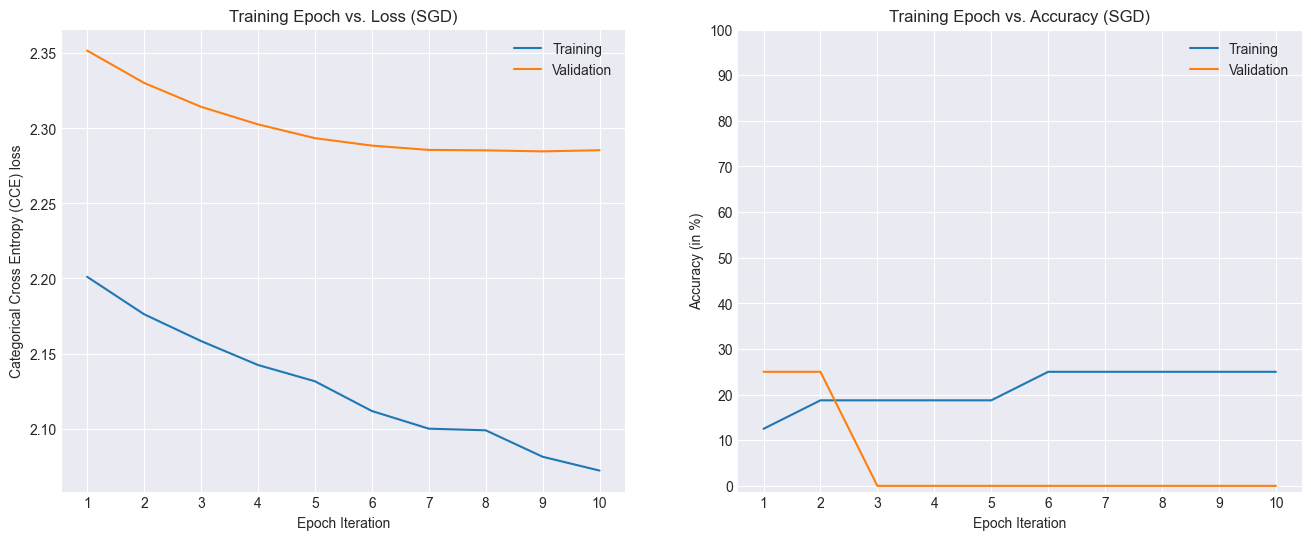

In [ ]:
# [FE Stats]: Run this cell if a new model is meant to be created
ma.show_analysis_charts(balanced_mlp_history["train_losses"], balanced_mlp_history["train_accs"], balanced_mlp_history["val_losses"], balanced_mlp_history["val_accs"])


In [6]:
balanced_mlp_train_predictions, balanced_mlp_train_labels = ma.run_predict_forward_pytorch(balanced_mlp_classifier, train_dataloader, accel_device, dtype)

balanced_mlp_val_preditions, balanced_mlp_val_labels = ma.run_predict_forward_pytorch(balanced_mlp_classifier, val_dataloader, accel_device, dtype)


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00         1
       Linde       0.00      0.00      0.00         2
       Palla       0.00      0.00      0.00         1
         Alm       0.50      0.50      0.50         2
         Roy       0.33      0.33      0.33         3
      Lilina       0.00      0.00      0.00         2
      Claude       0.00      0.00      0.00         3
    Lysithea       0.29      1.00      0.44         2

    accuracy                           0.25        16
   macro avg       0.14      0.23      0.16        16
weighted avg       0.16      0.25      0.18        16

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00       1.0
       Linde       0.00      0.00      0.00       1.0
       Palla       0.00      0.00      0.00       1.0
         Alm       0.00      0.00      0.00       0.

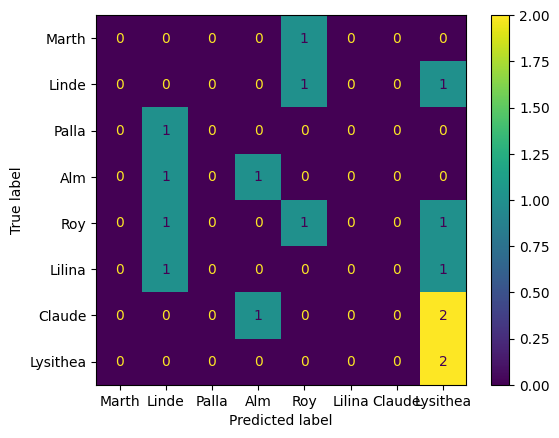

[INFO] Validation Confusion Matrix:


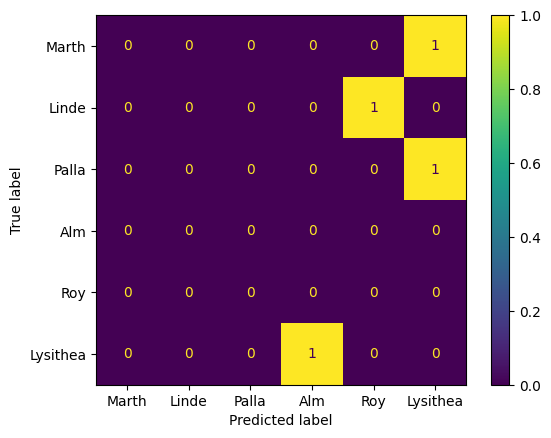

In [7]:
ma.show_metrics(balanced_mlp_train_predictions,
                balanced_mlp_train_labels,
                label_names,
                balanced_mlp_val_preditions,
                balanced_mlp_val_labels)


- *Saving the model*

In [9]:
torch.save(balanced_mlp_classifier.state_dict(), full_balanced_mlp_save_dir)


- *Test set inferences*

In [6]:
balanced_mlp_test_predictions, balanced_mlp_test_labels = ma.run_predict_forward_pytorch(balanced_mlp_classifier, test_dataloader, accel_device, dtype)


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00       1.0
       Palla       0.00      0.00      0.00       1.0
         Alm       0.00      0.00      0.00       1.0
      Lilina       0.00      0.00      0.00       1.0
    Lysithea       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0

[INFO] Training Confusion Matrix:


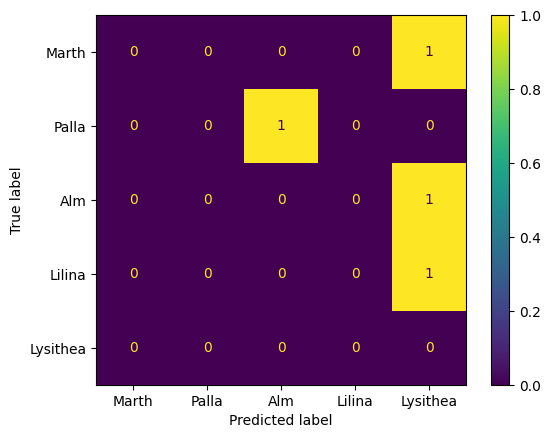

In [ ]:
ma.show_metrics(balanced_mlp_test_predictions,
                balanced_mlp_test_labels,
                label_names)


### **Convolutional Neural Network**

#### *Balanced Complexity*

- *Initializations*

In [12]:
full_balanced_cnn_save_dir = save_dir + "fe_stats_balanced_cnn_classifier.pt"

balanced_cnn_model_exists = False

import os.path
balanced_cnn_model_exists = os.path.isfile(full_balanced_cnn_save_dir)


In [13]:
balanced_cnn_classifier = FECNNClassifier(num_features, num_classes, accel_device, dtype)

if (balanced_cnn_model_exists):
    balanced_cnn_classifier.load_state_dict(torch.load(full_balanced_cnn_save_dir, weights_only=True))

    print("[INFO] Loaded existing model!")

balanced_cnn_classifier


[INFO] Loaded existing model!


FECNNClassifier(
  (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (out_layer): Linear(in_features=56, out_features=8, bias=True)
  (batch_norm1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (flat_layer): Flatten(start_dim=1, end_dim=-1)
)

- *Training loop*

In [6]:
# [FE Stats]: Run this cell if a new model is meant to be created
balanced_cnn_history = ma.run_train_forward_pytorch(balanced_cnn_classifier, train_dataloader, val_dataloader, num_epochs, baseline_sgd_config, True, accel_device, dtype)


[INFO] Epoch 1/100: Train/Validation loss = 2.1873/2.0758, train/validation accuracy = 18.75%/25.00%

[INFO] Epoch 2/100: Train/Validation loss = 2.1331/2.0690, train/validation accuracy = 12.50%/25.00%

[INFO] Epoch 3/100: Train/Validation loss = 2.2404/2.0665, train/validation accuracy = 6.25%/25.00%

[INFO] Epoch 4/100: Train/Validation loss = 2.1176/2.0602, train/validation accuracy = 18.75%/25.00%

[INFO] Epoch 5/100: Train/Validation loss = 2.2183/2.0651, train/validation accuracy = 6.25%/25.00%



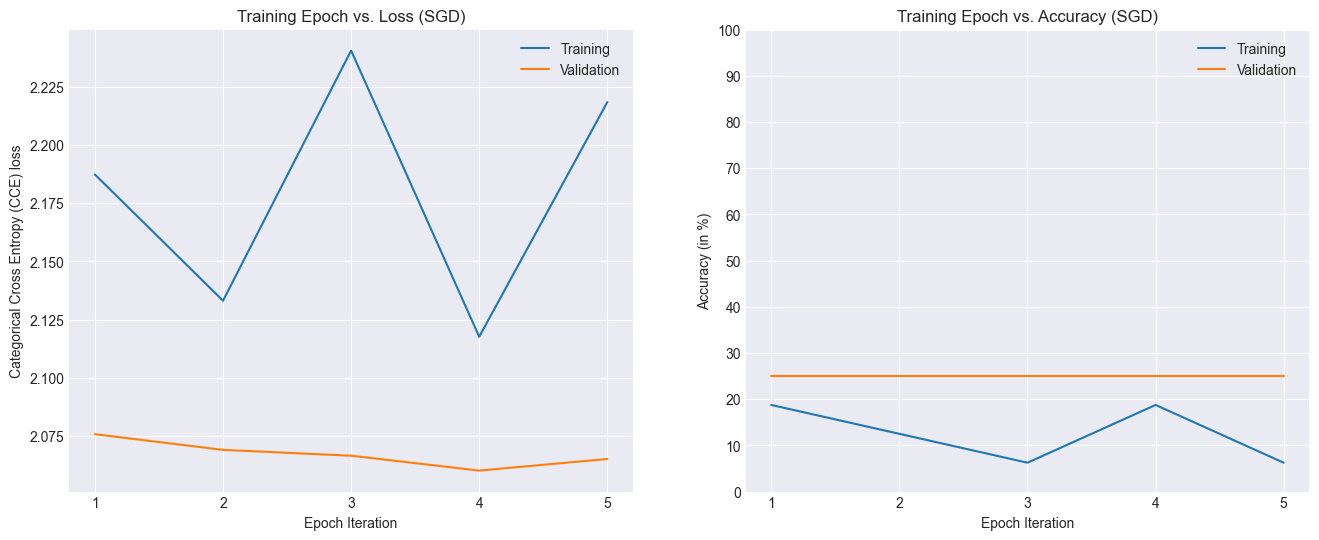

In [7]:
# [FE Stats]: Run this cell if a new model is meant to be created
ma.show_analysis_charts(balanced_cnn_history["train_losses"], balanced_cnn_history["train_accs"], balanced_cnn_history["val_losses"], balanced_cnn_history["val_accs"])


In [14]:
balanced_cnn_train_predictions, balanced_cnn_train_labels = ma.run_predict_forward_pytorch(balanced_cnn_classifier, train_dataloader, True, accel_device, dtype)

balanced_cnn_val_preditions, balanced_cnn_val_labels = ma.run_predict_forward_pytorch(balanced_cnn_classifier, val_dataloader, True, accel_device, dtype)


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.09      1.00      0.17         1
       Linde       0.00      0.00      0.00         2
       Palla       0.00      0.00      0.00         1
         Alm       0.00      0.00      0.00         2
         Roy       0.00      0.00      0.00         3
      Lilina       0.00      0.00      0.00         2
      Claude       0.00      0.00      0.00         3
    Lysithea       0.00      0.00      0.00         2

    accuracy                           0.06        16
   macro avg       0.01      0.12      0.02        16
weighted avg       0.01      0.06      0.01        16

[INFO] Training Confusion Matrix:


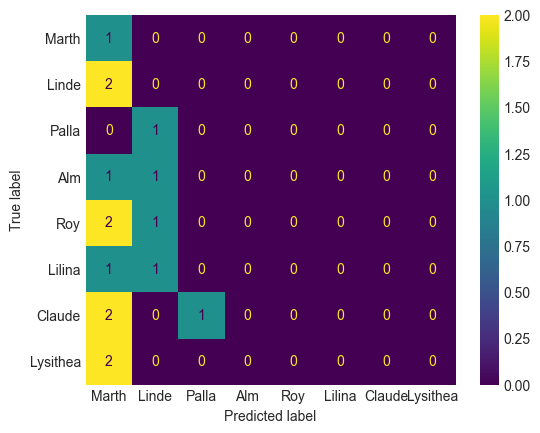

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

       Marth       0.25      1.00      0.40         1
       Linde       0.00      0.00      0.00         1
       Palla       0.00      0.00      0.00         1
    Lysithea       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.06      0.25      0.10         4
weighted avg       0.06      0.25      0.10         4

[INFO] Validation Confusion Matrix:


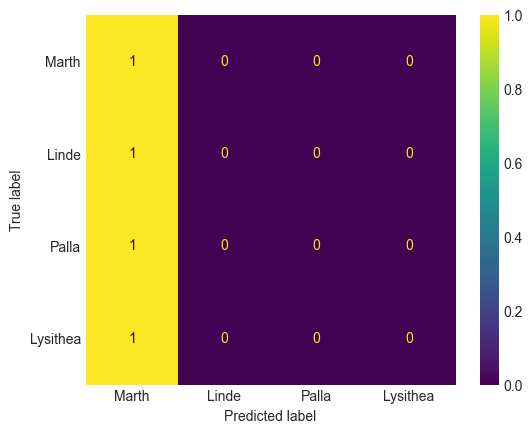

In [15]:
ma.show_metrics(balanced_cnn_train_predictions,
                balanced_cnn_train_labels,
                label_names,
                balanced_cnn_val_preditions,
                balanced_cnn_val_labels)


- *Saving the model*

In [10]:
torch.save(balanced_cnn_classifier.state_dict(), full_balanced_cnn_save_dir)


- *Test set inferences*

In [16]:
balanced_cnn_test_predictions, balanced_cnn_test_labels = ma.run_predict_forward_pytorch(balanced_cnn_classifier, test_dataloader, True, accel_device, dtype)


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.25      1.00      0.40         1
       Palla       0.00      0.00      0.00         1
         Alm       0.00      0.00      0.00         1
      Lilina       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.06      0.25      0.10         4
weighted avg       0.06      0.25      0.10         4

[INFO] Training Confusion Matrix:


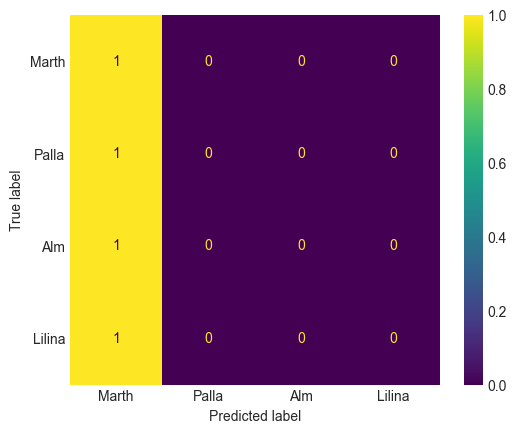

In [17]:
ma.show_metrics(balanced_cnn_test_predictions,
                balanced_cnn_test_labels,
                label_names)


### **Support Vector Machine**

#### *Balanced Complexity*

- *Initializations*

In [ ]:
full_balanced_svm_save_dir = save_dir + "fe_stats_balanced_svm_classifier.pkl"

balanced_svm_model_exists = False

import os.path
balanced_svm_model_exists = os.path.isfile(full_balanced_svm_save_dir)


In [30]:
balanced_svm_classifier = SVC(random_state=42)

if (balanced_svm_model_exists):
    with open(full_balanced_svm_save_dir, 'rb') as f:
        balanced_svm_classifier = pickle.load(f)

    print("[INFO] Loaded existing model!")

balanced_svm_classifier


SVC(random_state=42)

- *Training loop*

In [31]:
# [FE Stats]: Run this cell if a new model is meant to be created
balanced_svm_classifier.fit(numpy_train_dataset[:,:-1], numpy_train_dataset[:,-1])


SVC(random_state=42)

In [32]:
balanced_svm_train_predictions, balanced_svm_train_labels = (balanced_svm_classifier.predict(numpy_train_dataset[:,:-1]),numpy_train_dataset[:,-1])

balanced_svm_val_preditions, balanced_svm_val_labels = (balanced_svm_classifier.predict(numpy_val_dataset[:,:-1]),numpy_val_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00         1
       Linde       0.00      0.00      0.00         2
       Palla       0.00      0.00      0.00         1
         Alm       0.00      0.00      0.00         2
         Roy       0.22      0.67      0.33         3
      Lilina       0.00      0.00      0.00         2
      Claude       0.29      0.67      0.40         3
    Lysithea       0.00      0.00      0.00         2

    accuracy                           0.25        16
   macro avg       0.06      0.17      0.09        16
weighted avg       0.10      0.25      0.14        16

[INFO] Training Confusion Matrix:


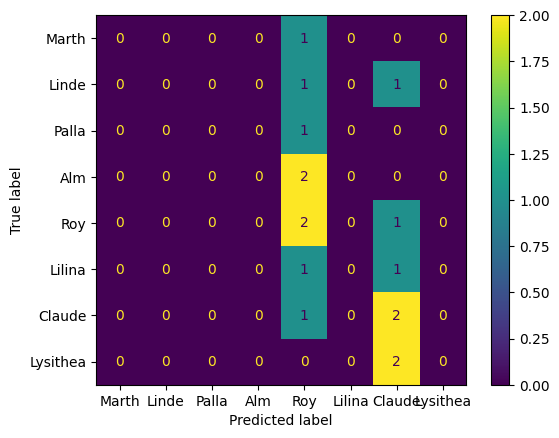

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00       1.0
       Linde       0.00      0.00      0.00       1.0
       Palla       0.00      0.00      0.00       1.0
         Roy       0.00      0.00      0.00       0.0
      Claude       0.00      0.00      0.00       0.0
    Lysithea       0.00      0.00      0.00       1.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0

[INFO] Validation Confusion Matrix:


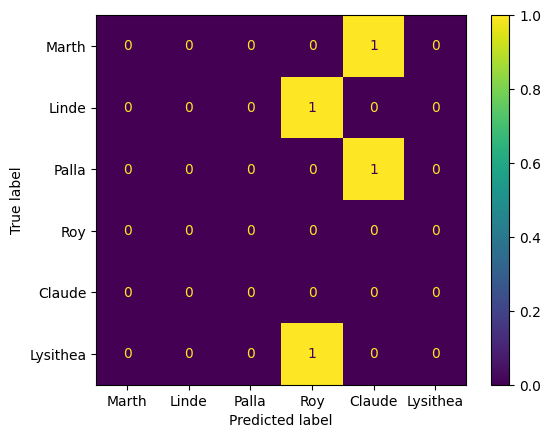

In [38]:
ma.show_metrics(list(balanced_svm_train_predictions),
                list(balanced_svm_train_labels),
                label_names,
                list(balanced_svm_val_preditions),
                list(balanced_svm_val_labels))


- *Saving the model*

In [39]:
with open(full_balanced_svm_save_dir, 'wb') as f:
        pickle.dump(balanced_svm_classifier, f)


- *Test set inferences*

In [40]:
balanced_svm_test_predictions, balanced_svm_test_labels = (balanced_svm_classifier.predict(numpy_test_dataset[:,:-1]),numpy_test_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00       1.0
       Palla       0.00      0.00      0.00       1.0
         Alm       0.00      0.00      0.00       1.0
         Roy       0.00      0.00      0.00       0.0
      Lilina       0.00      0.00      0.00       1.0
      Claude       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0

[INFO] Training Confusion Matrix:


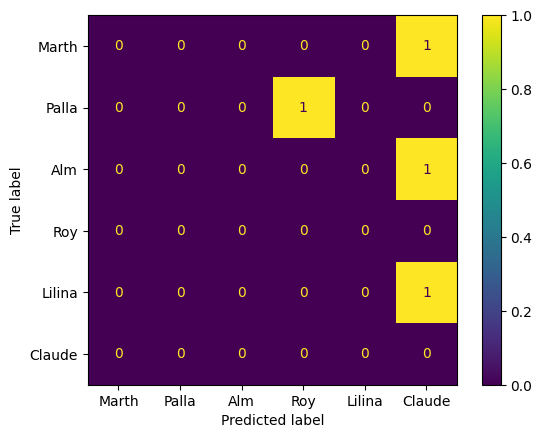

In [ ]:
ma.show_metrics(list(balanced_svm_test_predictions),
                list(balanced_svm_test_labels),
                label_names)


### **Decision Tree**

#### *Balanced Complexity*

- *Initializes*

In [26]:
full_balanced_tree_save_dir = save_dir + "fe_stats_balanced_tree_classifier.pkl"

full_optimized_tree_save_dir = save_dir + "fe_stats_optimized_tree_classifier.pkl"

balanced_tree_model_exists = False

optimized_tree_model_exists = False

import os.path
balanced_tree_model_exists = os.path.isfile(full_balanced_tree_save_dir)

optimized_tree_model_exists = os.path.isfile(full_optimized_tree_save_dir)


In [5]:
balanced_tree_classifier = RandomForestClassifier(random_state=42)

if (balanced_tree_model_exists):
    with open(full_balanced_tree_save_dir, 'rb') as f:
        balanced_tree_classifier = pickle.load(f)

    print("[INFO] Loaded existing model!")

balanced_tree_classifier


RandomForestClassifier(random_state=42)

- *Training loop*

In [6]:
# [FE Stats]: Run this cell if a new model is meant to be created
balanced_tree_classifier.fit(numpy_train_dataset[:,:-1], numpy_train_dataset[:,-1])


RandomForestClassifier(random_state=42)

In [7]:
balanced_tree_train_predictions, balanced_tree_train_labels = (balanced_tree_classifier.predict(numpy_train_dataset[:,:-1]),numpy_train_dataset[:,-1])

balanced_tree_val_preditions, balanced_tree_val_labels = (balanced_tree_classifier.predict(numpy_val_dataset[:,:-1]),numpy_val_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       1.00      1.00      1.00         1
       Linde       1.00      1.00      1.00         2
       Palla       1.00      1.00      1.00         1
         Alm       1.00      1.00      1.00         2
         Roy       1.00      1.00      1.00         3
      Lilina       1.00      1.00      1.00         2
      Claude       1.00      1.00      1.00         3
    Lysithea       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

[INFO] Training Confusion Matrix:


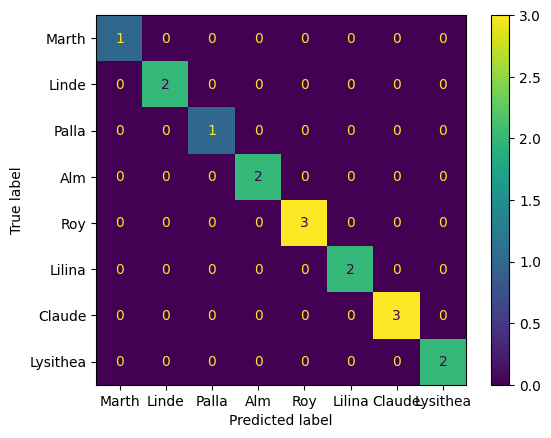

[INFO] Validation Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00         1
       Linde       0.50      1.00      0.67         1
       Palla       0.00      0.00      0.00         1
         Roy       0.00      0.00      0.00         0
    Lysithea       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.10      0.20      0.13         4
weighted avg       0.12      0.25      0.17         4

[INFO] Validation Confusion Matrix:


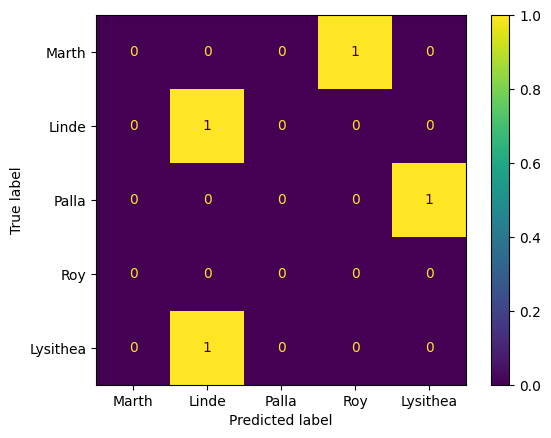

In [8]:
ma.show_metrics(list(balanced_tree_train_predictions),
                list(balanced_tree_train_labels),
                label_names,
                list(balanced_tree_val_preditions),
                list(balanced_tree_val_labels))


- *Saving the model*

In [9]:
with open(full_balanced_tree_save_dir, 'wb') as f:
        pickle.dump(balanced_tree_classifier, f)


- *Test set inferences*

In [10]:
balanced_tree_test_predictions, balanced_tree_test_labels = (balanced_tree_classifier.predict(numpy_test_dataset[:,:-1]),numpy_test_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00       1.0
       Palla       0.00      0.00      0.00       1.0
         Alm       0.00      0.00      0.00       1.0
         Roy       0.00      0.00      0.00       0.0
      Lilina       0.00      0.00      0.00       1.0
    Lysithea       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0

[INFO] Training Confusion Matrix:


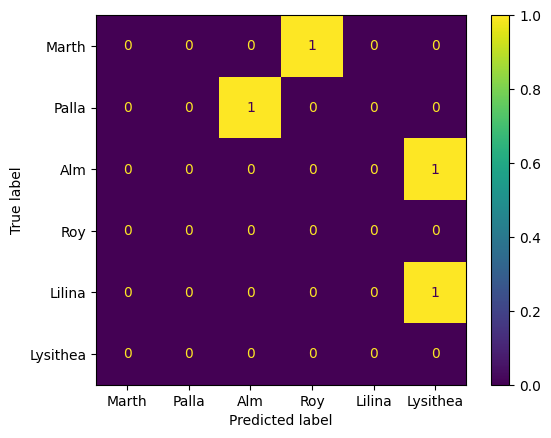

In [11]:
ma.show_metrics(list(balanced_tree_test_predictions),
                list(balanced_tree_test_labels),
                label_names)


- *Cross Validation Hyperparameter Search*
    - *Hyperparameters to test*
        - *n_estimators {4, 8, 16, ..., 96}*
        - *max_depth {8, 7, 6, 5, 4}*
        - *max_features {2, 3, 4, 5, 6}*
        - *k {2, 3, 4, 5, 6}*

In [29]:
# [FE Stats]: Run this cell and the next if a new search is meant to be done
train_dataset_iteration = next(iter(torch_data.DataLoader(train_dataset, len(train_dataset), True)))
numpy_train_dataset = numpy.hstack((train_dataset_iteration[0].cpu().numpy(),train_dataset_iteration[1].view((-1,1)).cpu().numpy()))

balanced_tree_hyperparameters = {
    "n_estimators": [4, 8, 16, 32, 64, 96],
    "max_depth": [8, 7, 6, 5, 4],
    "max_features": [2, 3, 4, 5, 6]
}

random_forest_classifier = RandomForestClassifier(random_state=42)

# CV set to 3 to avoid crashes due to low amount of data
random_tree_search = RandomizedSearchCV(random_forest_classifier, balanced_tree_hyperparameters, cv=3, random_state=42)
search_result = random_tree_search.fit(numpy_train_dataset[:,:-1], numpy_train_dataset[:,-1])
print(search_result.best_params_)


c:\Users\Trim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'n_estimators': 64, 'max_features': 6, 'max_depth': 5}


In [30]:
optimized_tree_classifier = RandomForestClassifier(n_estimators=search_result.best_params_["n_estimators"],
                                                    max_features=search_result.best_params_["max_features"],
                                                    max_depth=search_result.best_params_["max_depth"],
                                                    random_state=42)
optimized_tree_classifier


RandomForestClassifier(max_depth=5, max_features=6, n_estimators=64,
                       random_state=42)

In [28]:
# [FE Stats]: Run this cell if an existing model is meant to be loaded
optimized_tree_classifier = RandomForestClassifier(random_state=42)

if (optimized_tree_model_exists):
    with open(full_optimized_tree_save_dir, 'rb') as f:
        optimized_tree_classifier = pickle.load(f)

    print("[INFO] Loaded existing model!")

optimized_tree_classifier


RandomForestClassifier(random_state=42)

In [31]:
optimized_tree_classifier.fit(numpy_train_dataset[:,:-1], numpy_train_dataset[:,-1])


RandomForestClassifier(max_depth=5, max_features=6, n_estimators=64,
                       random_state=42)

In [32]:
optimized_tree_train_predictions, optimized_tree_train_labels = (optimized_tree_classifier.predict(numpy_train_dataset[:,:-1]),numpy_train_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       1.00      1.00      1.00         1
       Linde       1.00      1.00      1.00         2
       Palla       1.00      1.00      1.00         1
         Alm       1.00      1.00      1.00         2
         Roy       1.00      1.00      1.00         3
      Lilina       1.00      1.00      1.00         2
      Claude       1.00      1.00      1.00         3
    Lysithea       1.00      1.00      1.00         2

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

[INFO] Training Confusion Matrix:


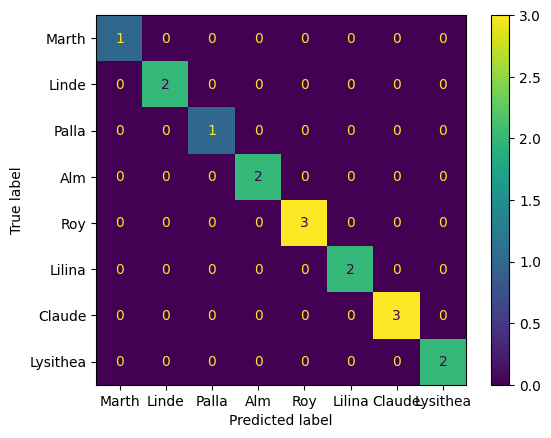

In [33]:
ma.show_metrics(list(optimized_tree_train_predictions),
                list(optimized_tree_train_labels),
                label_names)


In [34]:
with open(full_optimized_tree_save_dir, 'wb') as f:
        pickle.dump(optimized_tree_classifier, f)


In [35]:
optimized_tree_test_predictions, optimized_tree_test_labels = (optimized_tree_classifier.predict(numpy_test_dataset[:,:-1]),numpy_test_dataset[:,-1])


[INFO] Training Classification Report:
              precision    recall  f1-score   support

       Marth       0.00      0.00      0.00         1
       Palla       0.00      0.00      0.00         1
         Alm       0.00      0.00      0.00         1
         Roy       0.00      0.00      0.00         0
      Lilina       1.00      1.00      1.00         1
      Claude       0.00      0.00      0.00         0

    accuracy                           0.25         4
   macro avg       0.17      0.17      0.17         4
weighted avg       0.25      0.25      0.25         4

[INFO] Training Confusion Matrix:


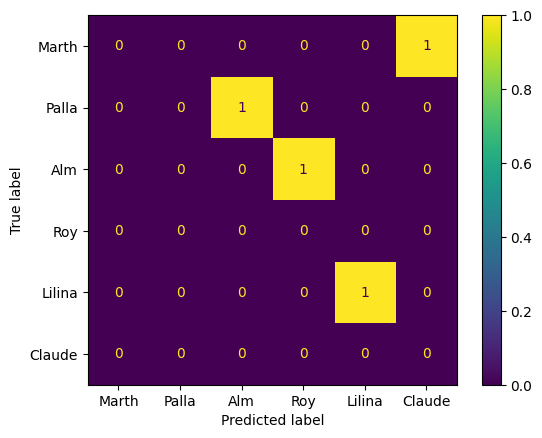

In [36]:
ma.show_metrics(list(optimized_tree_test_predictions),
                list(optimized_tree_test_labels),
                label_names)
